# <a href="https://miptstats.gitlhub.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 7. Кластеризация и понижение размерности

**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографиями в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив их как файл (`pdf`/`png`/`jpg`) боту вместе с ноутбуком
    * *или* вставив ее в ноутбук посредством `Edit -> Insert Image` при редактировании markdown-ячейки (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). **<font color="red">Неправильно вставленные фотографии могут не передаться при отправке.</font>** Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* **В решениях поясняйте, чем вы пользуетесь**, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.



**Баллы за задание:**

* Задача 1 &mdash; 30 баллов
* Задача 2 &mdash; 30 баллов
* Задача 3 &mdash; 120 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
# Bot check

# HW_ID: fpmi_ad7
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

При необходимости установите библиотеку-расширение для `plotly`, позволяющую рисовать картинки на всплывающих окнах.

    pip install dash

In [2]:
import io
import os
import base64

import numpy as np
import pandas as pd
from tqdm.cli import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import plotly.express as px
from dash import Dash, dcc, html, Input, Output, no_update, callback

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import torch
from transformers import ViTImageProcessor, ViTModel
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances

sns.set_theme(style="darkgrid", palette="Set2")

<font size="4"><b>Внимание! Файл с решением может быть тяжелым. Если он весит 20 Мб и более, заранее разделите его на несколько частей.</b></font>

---
### Задача 1. 

Докажите, что метод KMeans делит все пространство объектов на выпуклые многоугольники, возможно, неограниченные.

Можно понять, что при проведении алгоритма KMeans появляется диаграмма Вороного, так как в ней как раз пространство разбивается на области, которые образуют множества точек, более близких к одному из элементов множества, а это как раз то что мы и делаем в алгоритме. В силу свойств этой диаграммы можно сказать, что все многоугольники в которых лежат кластеры являются выпуклыми.

Также можно просто рассмотреть 2 произвольные точки x и y из одного кластера. На каждой итерации алгоритма отрезок xy будет полностью лежать в кластере в силу того, что эти 2 точки ближе к своему центру, чем к любому другому. А это как раз и соответствует определению выпуклого многоугольника.

---
### Задача 2. 

Как мы знаем из <a href="https://miptstats.github.io/courses/ad_fivt/lecture8.pdf">лекции</a>, в пространствах большой размерности расстояния между случайными объектами становятся неинформативными. Эта проблема известна как *проклятие размерности*, и она влечет соответствующие ограничения на использование методов, основанных на использовании расстоянии между объектами.

В этой задаче предлагается промоделировать ситуацию понижения размерности. Сгенерируйте достаточно большое количество точек в единичном кубе в пространстве некоторой размерности. Пример кода дан ниже

In [3]:
sample_size = 1000
dimention = 100
sample = np.random.uniform(size=(sample_size, dimention))

Повторите генерацию для нескольких размерностей пространства от 2 до 1000. Используйте не менее 7 различных значений размерностей пространства.

In [4]:
def generate_points(sample_size, dimension):
    return np.random.uniform(size=(sample_size, dimension))
dimensions = list(range(2, 1001, 100))

Для каждой размерности посчитайте норму каждой точки, тем самым получая набор значений расстояния от 0 до случайной точки. Нормируйте все расстояния, поделив на среднее полученных расстояний для каждой размерности пространства.

In [5]:
def calculate_norms(points):
    return np.linalg.norm(points, axis=1)

def normalize_distances(distances):
    return distances / np.mean(distances)

normalized_distances = {}

for dim in dimensions:
    points = generate_points(sample_size, dim)
    norms = calculate_norms(points)
    normalized_distances[dim] = normalize_distances(norms)

Нарисуйте на одном графике <a href="https://miptstats.github.io/courses/python/09_seaborn.html#3.-Оценки-плотности" target="_blank">KDE-оценки плотности</a> нормированных расстояний для каждой размерности пространства.

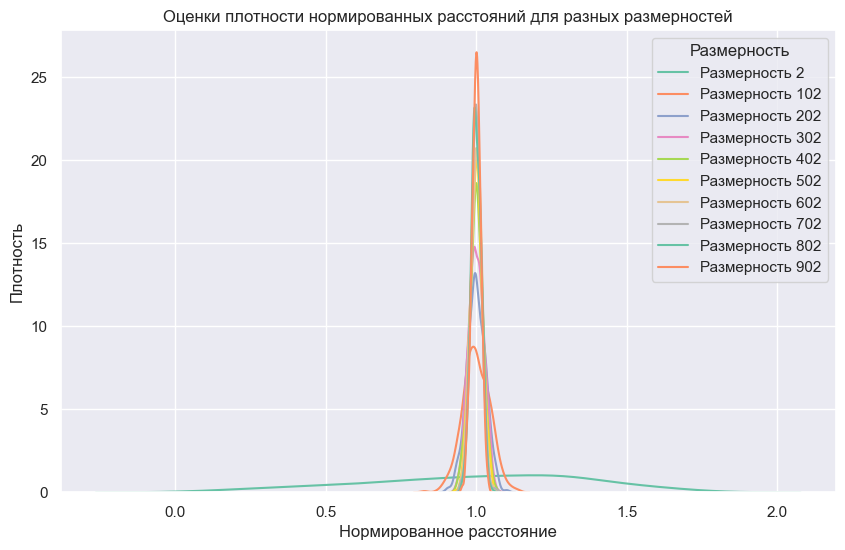

In [6]:
plt.figure(figsize=(10, 6))
for dim in dimensions:
    sns.kdeplot(normalized_distances[dim], label=f'Размерность {dim}')

plt.title('Оценки плотности нормированных расстояний для разных размерностей')
plt.xlabel('Нормированное расстояние')
plt.ylabel('Плотность')
plt.legend(title='Размерность')
plt.show()

Сделайте выводы

По графику видно, что "проклятие размерности" действительно проявляется, так как при увеличении размерности расстояние между точками становится менее информативным. Также видно, что плотность распределения при больших размерностях сильно различается и становится более высокой ближе к расстоянию 1.

---
### Задача 3.

В этой задаче мы попробуем кластеризовать различными способами изображения котиков из датасета с <a href="https://miptstats.github.io/courses/ad_fivt/pca.html" target="_blank">семинара</a>.

Скачайте данные, загрузите их и отрисуйте несколько примеров.

Размерность cats: (15747, 12288)


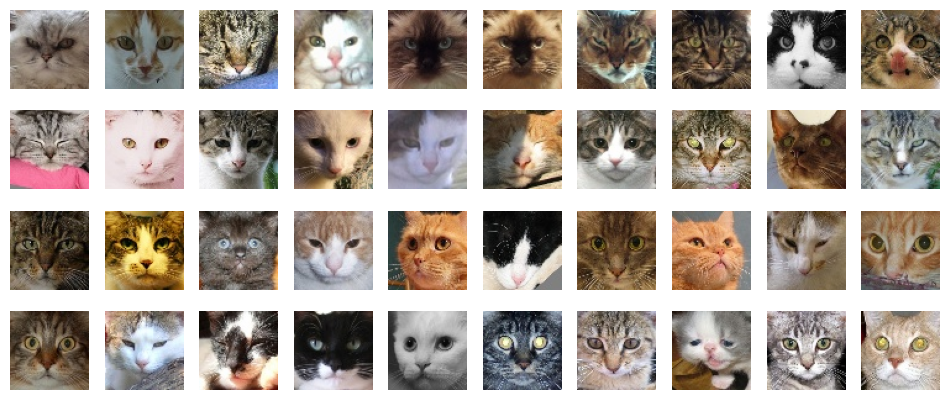

In [7]:
cats_path = "cats"
cats = []

for filename in os.listdir(cats_path):
    cats.append(plt.imread(os.path.join(cats_path, filename)))

cats = np.stack(cats).reshape(-1, 64 * 64 * 3)
print(f"Размерность cats: {cats.shape}")

# Визуализируем примеры
plt.figure(figsize=(12, 5))
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.imshow(cats[i].reshape(64, 64, 3))
    plt.axis("off")

#### 1. Свойства метрики в пространстве котиков

Прежде всего давайте исследуем, наблюдается ли проблема проклятия размерности в пространстве котиков, фактически повторив исследование предыдущей задачи. Для этого выберите не менее 10000 случайных пар изображений и посчитайте расстояния между ними. Визуализируйте <a href="https://miptstats.github.io/courses/python/09_seaborn.html#3.-Оценки-плотности" target="_blank">KDE-оценку плотности</a> нормированных расстояний.

Повторите те же действия к результату применения PCA, рассмотрев разное количество компонент, например, для 30, 100 и 500. Обратите внимание, что PCA нужно обучать на всех изображениях, а не только для тех, для которых вы будете считать расстояния. Примеры обучения PCA можно посмотреть в <a href="https://miptstats.github.io/courses/ad_fivt/pca.html" target="_blank">ноутбуке</a> с занятия.

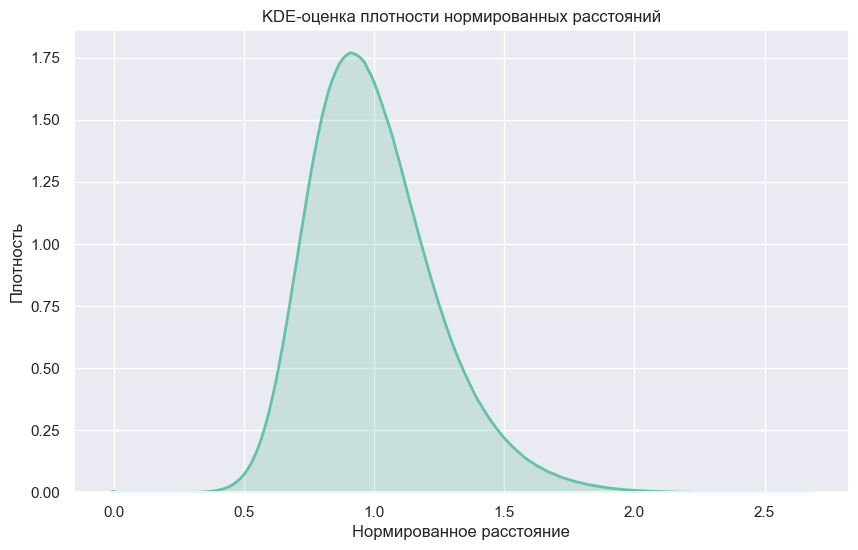

In [18]:
first_index = np.random.choice(len(cats), size=10000)
second_index = np.random.choice(len(cats), size=10000)

first_cats = cats[first_index]
second_cats = cats[second_index]

distances = pairwise_distances(first_cats.reshape(len(first_index), -1), second_cats.reshape(len(second_index), -1))

normalized_distances = normalize_distances(distances)

plt.figure(figsize=(10, 6))
sns.kdeplot(normalized_distances.ravel(), fill=True, linewidth=2)
plt.title('KDE-оценка плотности нормированных расстояний')
plt.xlabel('Нормированное расстояние')
plt.ylabel('Плотность')
plt.show()

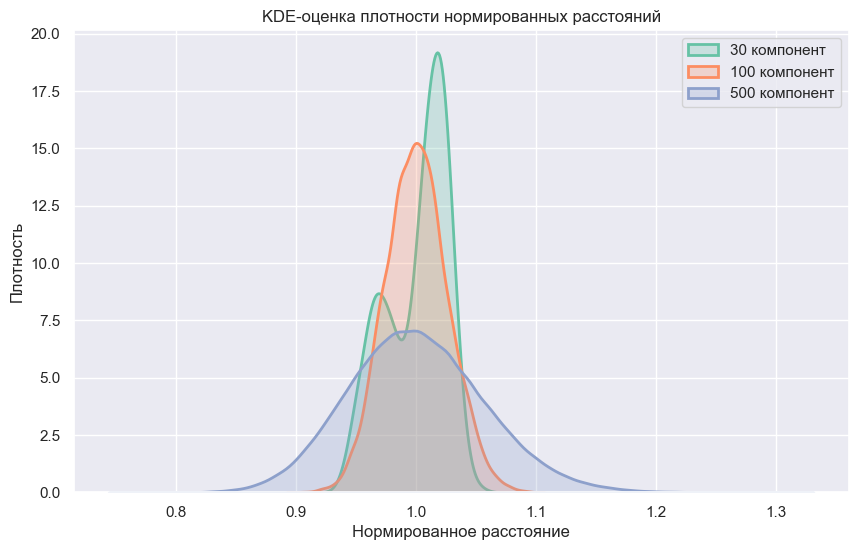

In [19]:
pca30 = PCA(n_components=30)
pca100 = PCA(n_components=100)
pca500 = PCA(n_components=500)

cats_projection30 = pca30.fit_transform(cats.reshape(len(cats), -1))
cats_projection100 = pca100.fit_transform(cats.reshape(len(cats), -1))
cats_projection500 = pca500.fit_transform(cats.reshape(len(cats), -1))

def prepare_data(projection, n_components):
    first_index = np.random.choice(len(projection), size=n_components)
    second_index = np.random.choice(len(projection), size=n_components)

    first_projection = projection[first_index]
    second_projection = projection[second_index]

    distances = pairwise_distances(first_cats.reshape(len(first_index), -1), second_cats.reshape(len(second_index), -1))

    normalized_distances = normalize_distances(distances)
    return normalized_distances

distances30 = prepare_data(cats_projection30, 30)
distances100 = prepare_data(cats_projection100, 100)
distances500 = prepare_data(cats_projection500, 500)

plt.figure(figsize=(10, 6))
sns.kdeplot(distances30.ravel(), fill=True, linewidth=2, label='30 компонент')
sns.kdeplot(distances100.ravel(), fill=True, linewidth=2, label='100 компонент')
sns.kdeplot(distances500.ravel(), fill=True, linewidth=2, label='500 компонент')

plt.title('KDE-оценка плотности нормированных расстояний')
plt.xlabel('Нормированное расстояние')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Сделайте выводы

С увеличением количества компонент в РСА модели плотность распределения становится все более гладкой и равномерной.

#### 2. Кластеризация котиков по вектору изображения

Начнем эксперименты с самого простого способа: каждое изображение можно вытянуть в вектор размерности $64 \cdot 64 \cdot 3$, их и попытаемся кластеризовать. Обучите по этим объектам метод KMeans, пример можно посмотреть в <a href="https://miptstats.github.io/courses/ad_fivt/clustering.html" target="_blank">ноутбуке</a> по кластеризации

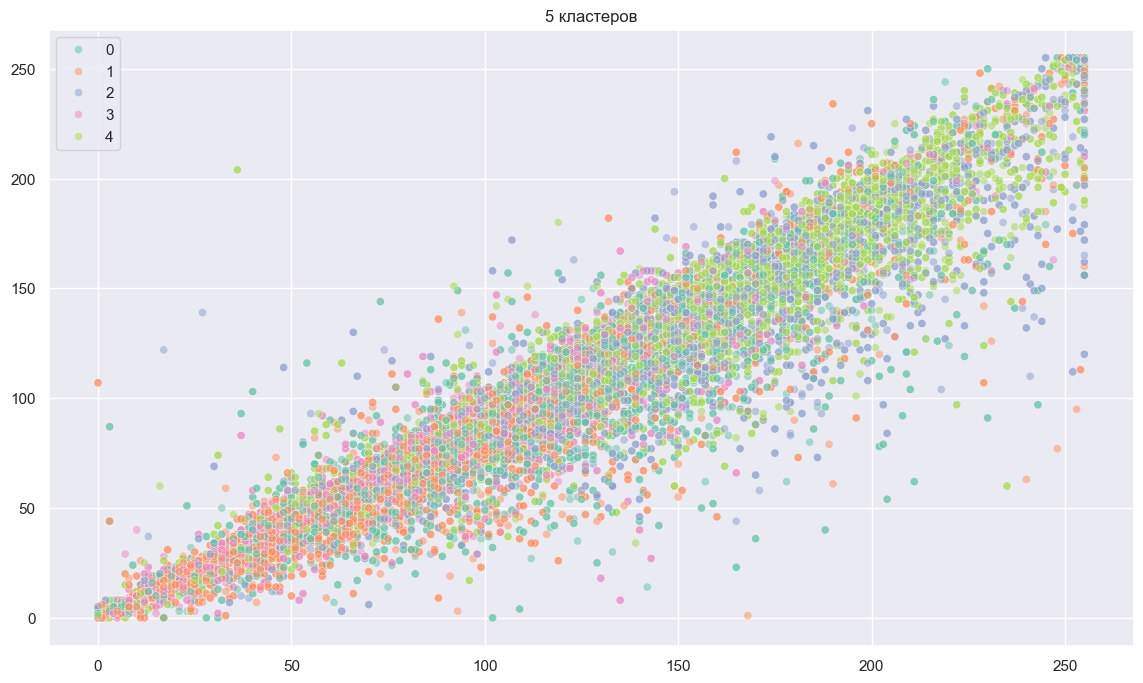

CPU times: total: 1min 4s
Wall time: 10.2 s


In [23]:
%%time
fig = plt.figure(figsize=(14, 8))
kmeans = KMeans(n_clusters=5, n_init="auto", random_state=42)
kmeans.fit(cats)
y_pred = kmeans.predict(cats)
sns.scatterplot(x=cats[:, 0], y=cats[:, 1], hue=y_pred, palette="Set2", alpha=0.5)
plt.title(f"5 кластеров")
plt.show()

Теперь отобразим изображения на плоскость с помощью PCA и визуализируем полученные предсказания цветом, как это было сделано на семинаре для ответов на вопросы в бот. Ниже уже реализована функция отрисовки `visualize_images_clusterisation`, вам требуется лишь применить PCA и вызвать функцию с правильными параметрами.

In [ ]:
def visualize_images_clusterisation(images, projection, clusters, port=None):
    """
    Визуализиует двумерную проекцию эмбеддингов изображений,
    во всплывающем окне показывает сами изображения

    :param images: набор изображений
    :param projection: двумерная проекция изображений или эмбеддингов изображений
    :param clusters: предсказанные кластера
    :param port: опциональный параметр, порт на котором поднимается визуализация:
                 одинаковые порты - одинаковые графики, но если в ноутбуке открыто много портов, то могут начаться лаги
    """
    # Рисуем график с точками как на семинаре
    fig = px.scatter(
        x=projection[:, 0],
        y=projection[:, 1],
        hover_name=clusters,
        hover_data={"image_idx": list(range(len(images)))},
        color=clusters.astype(str),
        width=1000,
        height=800,
        title="PCA проекция изображений на плоскость",
        size=[1] * len(images),
        size_max=12,
    )

    # Добавляем во всплывающее окошко (hover box) изображения
    fig.update_traces(
        hoverinfo="none",
        hovertemplate=None,
    )

    app = Dash(__name__)

    app.layout = html.Div(
        className="container",
        children=[
            dcc.Graph(id="graph-2-dcc", figure=fig, clear_on_unhover=True),
            dcc.Tooltip(id="graph-tooltip-2", direction="bottom"),
        ],
    )

    @callback(
        Output("graph-tooltip-2", "show"),
        Output("graph-tooltip-2", "bbox"),
        Output("graph-tooltip-2", "children"),
        Output("graph-tooltip-2", "direction"),
        Input("graph-2-dcc", "hoverData"),
    )
    def display_hover(hoverData):
        """
        Настраивает всплывающее окно hover box.

        :param hoverData: данные соответствующей точки
        """
        if hoverData is None:
            return False, no_update, no_update, no_update

        # Достаем индекс картинки, который выше положили в hover_data
        hover_data = hoverData["points"][0]
        image_idx = hover_data["customdata"][0]
        # И получаем само изображение кота
        image = Image.fromarray(images[image_idx].reshape(64, 64, 3))

        # Преобразовываем изображение в base64 кодировку
        buffer = io.BytesIO()
        image.save(buffer, format="jpeg")
        encoded_image = base64.b64encode(buffer.getvalue()).decode()
        image_url = "data:image/jpeg;base64, " + encoded_image

        image_children = [
            html.Img(
                src=image_url,
                style={"width": "196px"},
            ),
        ]

        return True, hover_data["bbox"], image_children, "top"

    if port is None:
        port = str(np.random.randint(5000, 15000))
    app.run(port=port, debug=True, jupyter_height=800)

    return app

In [ ]:
# <...>

Для каждого кластера нарисуйте по 5-10 типичных изображений, то есть ближайших к центру кластера. Похожую операцию мы видели на занятии в <a href="https://miptstats.github.io/courses/ad_fivt/clustering.html" target="_blank">ноутбуке</a> по кластеризации.

*Примечание.* Для одного кластера рисуйте картинки "в строчку". Так будет удобно как вам самим, так и проверяющему. Примеры можно посмотреть в <a href="https://miptstats.github.io/courses/ad_fivt/pca.html" target="_blank">ноутбуке</a> по PCA.

In [ ]:
# <...>

Наблюдаются ли какие-то закономерности в изображениях внутри одного кластера? Если да, то опишите отличительные черты кластеров.

<...>

Подумайте, чем может быть плох такой подход? Какая проблема могла возникнуть и возникла ли? Обратите внимание на проведенное ранее исследование.

<...>

#### 3. PCA + кластеризация

Попробуем уменьшить размерность перед кластеризацией с помощью PCA, спроектировав изображения на первые несколько главных компонент 

**Примечание.** Не стоит брать больше 100 главных компонент

Сделайте кластеризацию:

In [ ]:
%%time
# <...>

CPU times: total: 0 ns
Wall time: 0 ns


Визуализируйте полученные кластера:

In [ ]:
# <...>

Нарисуйте по 5-10 типичных изображений для новых кластеров

In [ ]:
# <...>

Опишите отличительные черты кластеров:

<...>

Сильно ли они отличаются от предыдущего способа?

<...>

#### 4. Нейросетевые эмбеддинги + кластеризация

Попробуем применить к изображениям такой же подход, как с текстами. То есть возьмем хорошую уже обученную нейросеть, получим с ее помощью эмбеддинги изображений и будем дулеть кластеризацию этих эмбеддингов.

Выберите на <a target="_blank" href="https://huggingface.co/models">huggingface</a> модель для получения эмбеддингов изображений.

**Примечания**
- Нам нужны `CV` модели для задачи извлечения признаков (в фильтрах huggingface называются `Image Feature Extraction`).
- Не выбирайте слишком тяжелые модели (с суффиксами `-huge`, `-giant`, `-large` и прочим), нам это ни к чему, так как картинки маленькие и простые. К тому же это замедлит предсказание эмбеддингов.
- Обычно в карточке модели есть пример применения, который можно скопировать и как в семинаре в цикле применить ко всем батчам изображениям.
- Некоторые модели могут возвращать не эмбеддинг размерности `(D,)`, а матрицу признаков размерности `(n, D)`, в этому случае надо применить average-pooling, усреднив по предпоследней оси.

Загрузите модель, примените к одному тестовому изображению кота и посмотрите на размерность полученного тензора

In [ ]:
example_image = cats[0].reshape(64, 64, 3)

# Загрузка и тестовое применение модели
# <...>

Теперь примените загруженную модель ко всем картинкам

In [ ]:
# <...>

Сделайте кластеризацию полученных эмбеддингов

In [ ]:
# <...>

Визуализируйте полученные кластера:

In [ ]:
# <...>

Нарисуйте по 5-10 типичных изображений для новых кластеров

In [ ]:
# <...>

Опишите отличительные черты кластеров:

<...>

Чем отличаются кластеры, полученные этим способом от первых двух?

<...>

#### 5. Выводы
Сделайте выводы: 

<...>